In [3]:
from functools import partial

import jax
import jax.lax as lax
import jax.numpy as jnp
import jax.random as jrng 

from jax import Array

import matplotlib.pyplot as plt

jnp.set_printoptions(precision=3)

In [4]:
seed = 0
n = 4 # Number of states
m = 3 # Number of observations

key = jrng.key(seed)
key, O_key, mu_key = jrng.split(key, 3)

# Construct a transition matrix that stays in the same state with 99% probability and transitions to the next with 1%
T = 0.99 * jnp.eye(n)
T = T + 0.01 * jnp.eye(n, k=1)
T = T / jnp.sum(T, axis=-1)[:,None]

# Construct an initial state distribution where the earlier states are more likely
mu = jnp.exp(- 5 * jnp.arange(0, n))
mu = mu.at[n -1].set(0)
mu = mu / jnp.sum(mu)

# Construct a noisy observation matrix
O = jrng.uniform(O_key, (n, m))
O = O * jnp.linspace(0, 1, n)[:, None]
for s in range(n):
    O = O.at[s, (s * m) // n ].set(.5)
O = O.at[n-1].set(0.0)
O = O.at[n-1, m-1].set(1.0)
O = O / jnp.sum(O, axis=-1)[:,None]

print("T row sums:", jnp.sum(T, axis=-1), 
      "\nO row sums:", jnp.sum(O, axis=-1), 
      "\nmu sum:", jnp.sum(mu)[None])

T row sums: [1. 1. 1. 1.] 
O row sums: [1. 1. 1. 1.] 
mu sum: [1.]


# Likelihood computation of a sequence

We now look at the likelihood of a sequence of observations $o_1, \dots, o_T$ given a set of parameters $T, O, \mu$

In [194]:
@partial(jax.jit, static_argnames="length")
def generate_sequence(
        key: Array,
        transition_matrix: Array, 
        observation_matrix: Array, 
        initial_distribution: Array, 
        length: int) -> Array:

    n, _ = observation_matrix.shape

    initial_key, sampling_key = jrng.split(key)
    initial_state = jrng.choice(initial_key, n, p=initial_distribution)

    p_samples = jrng.uniform(sampling_key, (length, 2))

    obs_cdf = jnp.cumsum(observation_matrix, axis=-1)
    trans_cdf = jnp.cumsum(transition_matrix, axis=-1)

    def step(state, p_samples):
        p_obs, p_state = p_samples

        observation = jnp.argmax(obs_cdf[state] >= p_obs)
        next_state = jnp.argmax(trans_cdf[state] >= p_state)

        return next_state, (state, observation)
    
    _, (states, observations) = lax.scan(step, initial_state, p_samples)

    return states, observations

@partial(jax.jit, static_argnames="length")
def generate_sequence_choice(
        key: Array,
        transition_matrix: Array, 
        observation_matrix: Array, 
        initial_distribution: Array, 
        length: int) -> Array:

    n, m = observation_matrix.shape

    initial_key, *key_array = jrng.split(key, 1 + length)
    initial_state = jrng.choice(initial_key, n, p=initial_distribution)


    def step(state, sampling_key):
        obs_key, state_key = jrng.split(sampling_key)

        observation = jrng.choice(obs_key, m, p=observation_matrix[state])
        next_state = jrng.choice(state_key, n, p=transition_matrix[state])

        return next_state, (state, observation)
    
    _, (states, observations) = lax.scan(step, initial_state, jnp.array(key_array))

    return states, observations



In [195]:
generate_sequence(jrng.key(0), T, O, mu, 100)
generate_sequence_choice(jrng.key(0), T, O, mu, 100)

%timeit generate_sequence(jrng.key(0), T, O, mu, 100)
%timeit generate_sequence_choice(jrng.key(0), T, O, mu, 100)


890 μs ± 272 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
4.23 ms ± 3.56 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [196]:
n_sequences = 50_000
len_sequence = 1000

key = jrng.key(seed)
key, *sequence_keys = jrng.split(key, 1 + n_sequences)

states, observations = jax.vmap(lambda _key: generate_sequence(_key, T, O, mu, len_sequence))(jnp.array(sequence_keys))

In [197]:
@jax.jit
def likelihood(observations, T, O, mu):
    # Compute the likelihood of observing obs given the parameters T, O and mu

    def loop_body(state_likelihoods, obs):
        state_likelihoods = state_likelihoods @ T * O[:, obs]
        return state_likelihoods, jnp.sum(state_likelihoods)

    initial_likelihoods = mu * O[:, observations[0]]

    state_likelihoods, likelihood_sequence = lax.scan(
        loop_body,
        initial_likelihoods,
        observations[1:],
        unroll=False
    )

    state_likelihoods = jnp.concat(
        [initial_likelihoods, 
         state_likelihoods]
    )
    
    likelihood_sequence = jnp.concat(
        [jnp.sum(initial_likelihoods)[None], 
         likelihood_sequence]
    )

    return state_likelihoods, likelihood_sequence

In [198]:
# test_sequence = observations[5, ...]
test_sequence = jnp.zeros_like(observations[0, ...])

state_likelihoods, llhood_vec = likelihood(test_sequence, T, O, mu)

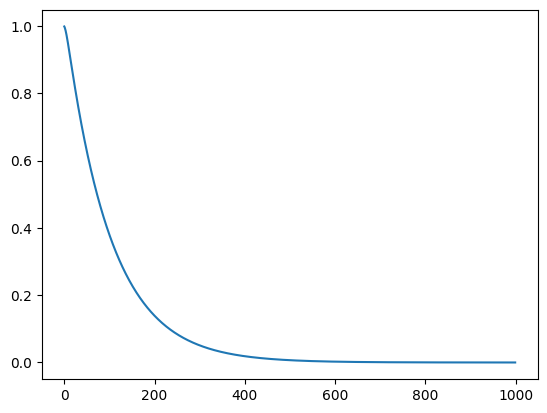

In [199]:
plt.plot(llhood_vec)
plt.show()

In [200]:
state_likelihoods, llhood_vec = likelihood(test_sequence, T, O, mu)

identical_indices = jnp.all(observations == test_sequence, axis=-1)
identical_samples = jnp.sum(identical_indices)

sampled_likelihood = identical_samples / observations.shape[0]

print("Likelihood sampled:", sampled_likelihood, "\nLikelihood computed:", llhood_vec[-1])

Likelihood sampled: 8e-05 
Likelihood computed: 4.5233908e-05


In [201]:
observations


Array([[0, 0, 0, ..., 2, 2, 2],
       [0, 0, 0, ..., 2, 2, 2],
       [0, 0, 0, ..., 2, 2, 2],
       ...,
       [0, 0, 0, ..., 2, 2, 2],
       [0, 0, 0, ..., 2, 2, 2],
       [0, 0, 0, ..., 2, 2, 2]], dtype=int32)

In [202]:
identical_indices

Array([False, False, False, ..., False, False, False], dtype=bool)

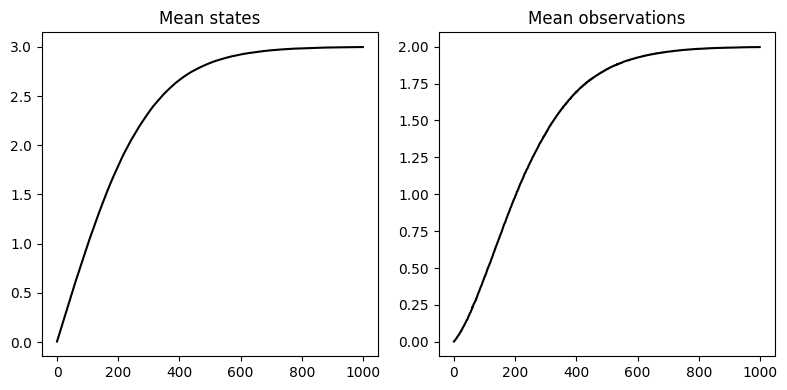

In [203]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(8,4)
n_samples = len(states)
ax[0].plot(jnp.mean(states, axis=0), "k")
ax[1].plot(jnp.mean(observations, axis=0), "k")
ax[0].set_title("Mean states")
ax[1].set_title("Mean observations")
plt.tight_layout()
plt.show()

In [204]:
state_distribution = lax.map(lambda s: jnp.count_nonzero(states == s, axis=0), jnp.arange(n)) / states.shape[0]
state_distribution

Array([[9.931e-01, 9.834e-01, 9.738e-01, ..., 1.000e-04, 1.000e-04,
        1.000e-04],
       [6.820e-03, 1.644e-02, 2.594e-02, ..., 3.600e-04, 3.600e-04,
        3.600e-04],
       [4.000e-05, 1.200e-04, 2.800e-04, ..., 2.000e-03, 1.980e-03,
        1.980e-03],
       [0.000e+00, 0.000e+00, 0.000e+00, ..., 9.975e-01, 9.976e-01,
        9.976e-01]], dtype=float32)

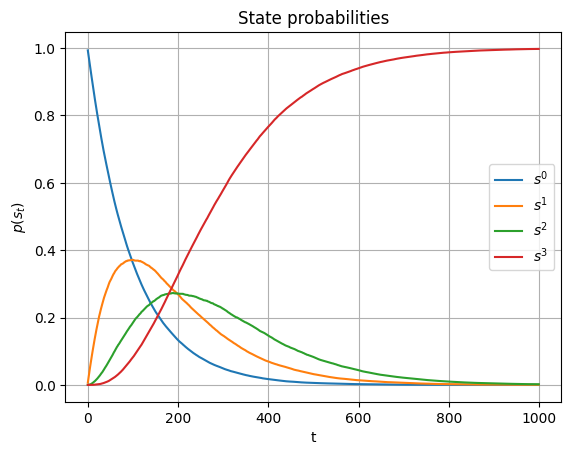

In [205]:
for k, state_prob in enumerate(state_distribution):
    plt.plot(state_prob, label=f"$s^{k}$")

plt.grid()
plt.legend()
plt.title("State probabilities")
plt.xlabel("t")
plt.ylabel("$p(s_t)$")
plt.show()

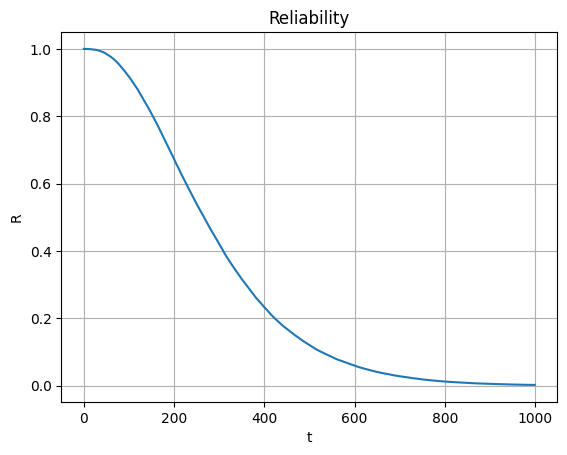

In [206]:
# Reliablility
p_failure = state_distribution[-1]
R = 1 - p_failure

plt.plot(R)
plt.grid()
plt.title("Reliability")
plt.xlabel("t")
plt.ylabel("R")
plt.show()
